## Error Mitigation for QNNs on IBM Devices

### Introduction

This tutorial demonstrates the setup and implementation of error mitigation techniques for Qiskit's primitives within the context of Quantum Neural Networks (QNNs) in sQUlearn. Firstly, we will train a small QNN using a noise-free and error-free simulator to fit a parabolic dataset. Subsequently, we will illustrate how to configure the `Executor` class to establish a connection with IBM Quantum devices. We assume that you have already set up an IBM account and have access to IBM Quantum devices. For detailed instructions on registering and configuring your IBM Quantum account, please refer to the following link: [IBM Quantum Account Management](https://qiskit.org/ecosystem/ibm-runtime/how_to/account-management.html).

Given the potentially lengthy queuing times for the free quantum devices, we will replicate the noise model of a quantum device and use the QASM simulator to emulate the real characteristics of a quantum computer. The simulator employed in this task, known as the `ibmq_qasm_simulator`, operates within the IBM Quantum cloud and can be accessed similarly to the actual quantum devices.

We will explore various error mitigation options for both the Estimator and Sampler primitives. Finally, we will demonstrate how to train the QNN on the quantum device (simulator) to adapt to noisy configurations and reduce finite sampling noise through variance regularization [1].

### Importing Libraries

The first step involves importing the necessary libraries for this tutorial. We will be using the `qiskit-ibm-runtime` package to establish connections with IBM Quantum devices and `qiskit-aer` to simulate the noise model of these quantum devices. Additionally, we will employ the `squlearn` library to configure and train the QNN on the quantum device.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator, Sampler
from qiskit_aer.noise import NoiseModel

from squlearn import Executor
from squlearn.encoding_circuit import QiskitEncodingCircuit
from squlearn.observables import SinglePauli
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SLSQP, SGLBO

### Set-up of the QNN

We first set-up the data encoding circuit of the QNN. Here we utilize the `ChebPQC` encoding circuit for 2 qubits and 2 layers.

C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


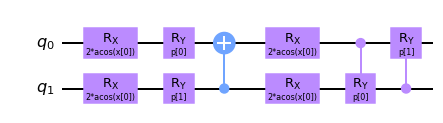

In [2]:
nqubits = 2

qc = QuantumCircuit(2)
p = ParameterVector('p', 2)
x = ParameterVector('x', 1)

qc.rx(2*np.arccos(x[0]), 0)
qc.rx(2*np.arccos(x[0]), 1)

qc.ry(p[0], 0)
qc.ry(p[1], 1)

qc.cx(1, 0)

qc.rx(2*np.arccos(x[0]), 0)
qc.rx(2*np.arccos(x[0]), 1)

qc.cry(p[0], 0, 1)
qc.cry(p[1], 1, 0)

pqc = QiskitEncodingCircuit(qc)
pqc.draw()

We utilize the parameterized summation over Z Pauli matrices as the observable: $\hat{O} = \hat{Z}_0 \beta$

In [3]:
op = SinglePauli(nqubits,qubit=0,parameterized=False)
print(op)

SparsePauliOp(['IZ'],
              coeffs=[1.+0.j])


In [4]:
op.num_parameters

0

Lastly, we configure the Quantum Neural Network (QNN) using the QNNRegressor class sourced from the squlearn library. In this setup, we initialize the QNN with randomized weights, employ the L2 Loss (also known as SquaredLoss), and utilize the Adam optimization routine with a learning rate set to 0.1. It's noteworthy that during the training process, the QNN leverages the statevector_simulator to calculate the expectation values of observables, thereby ensuring a noise-free and error-free training environment.

In [5]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.ones(op.num_parameters)
x0 = [[i * 0.02] for i in range(15)]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(0.0, 0.3)], "log_file": "sglbo_noiseless.log",
                     "bo_n_calls": 30, "bo_x0_points": x0, "maxiter": 100}

qnn_simulator = QNNRegressor(
    pqc,
    op,
    Executor("statevector_simulator"),
    SquaredLoss(),
    #SGLBO(optimizer_options),
    Adam({"lr": 0.2,"log_file": "adam_noiseless.log"}),
    param_ini,
    param_op_ini,
    opt_param_op=False, # Keine Observablen optimierung
    parameter_seed=124
)

### Training of the QNN with a noise free simulator

In this cell, we set-up the data `x_train` and `y_train` for training the QNN. The values are obtained by calculating the values of the simple parametric function $f(x) = x^2$ with the `square` function of `numpy`.

In [6]:
# Data that is inputted to the QNN
x_train = np.arange(-0.5, 0.6, 0.1)
# Data that is fitted by the QNN
y_train = np.square(x_train)-0.9

Afterwards, we train the QNN by calling the `fit` method of the `QNNRegressor` class.

In [7]:
qnn_simulator.fit(x_train, y_train)

fit: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

The finial parameters of the encoding circuit and the observable are displayed in the output of the following cell.

In [8]:
print("Result encoding parameters:", qnn_simulator.param)
print("Result observable parameters:", qnn_simulator.param_op)

Result encoding parameters: [-0.71624442  1.77373069]
Result observable parameters: []


Following the QNN's training, we proceed to compute model inferences and visualize the results. The QNN model generates the parabolic output, affirming the successful training of the QNN.


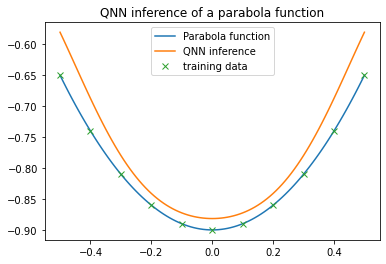

In [9]:
x = np.arange(np.min(x_train), np.max(x_train) + 0.01, 0.01)
y = qnn_simulator.predict(x)  # function for evaluating the prediction of the QNN
plt.plot(x, np.square(x)-0.9, label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference of a parabola function")
plt.show()